In [11]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

1. 사진 준비

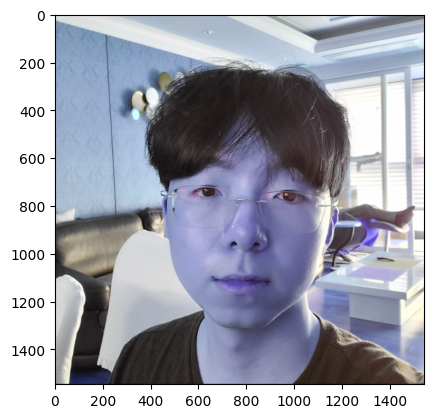

In [7]:
my_image_path = '../data/selfi.jpg' # 본인 이미지가 있는 경로를 가지고 온다.
img_bgr = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

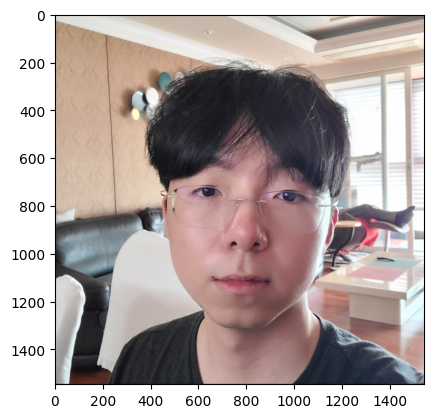

In [16]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

2. face 감지
* HOG를 이용하여 얼굴을 감지

https://hayunjong83.tistory.com/38

dlib 라이브러리에서는 얼굴 탐색을 위해 HOG특성을 활용하거나 또는 대신 학습된 CNN모델을 사용할 수 있다.

HOG는 픽셀값의 변화로 파악할 수 있는 영상 밝기 변화의 방향을 그래디언트(gradient)로 표현하고, 이로부터 객체의 형태를 찾아낼 수 있다. 얼굴 탐색 이외에도 보행자 검출 등에 활용할 수 있다.

 

dlib의 얼굴 탐색은 기본적으로 HOG 특성을 활용하므로 dlib.get_frontal_face_detector( )를 사용하면 기본 얼굴 검출기를 쓸 수 있다. 기본 얼굴탐색 객체는 사실 만들어진 이미지 피라미드(image pyramid)의 이미지들을 슬라이딩 윈도 방식(sliding window) 방식으로 탐색할 때, HOG특성을 사용한 뒤 그 결과를 분류하는 선형 분류기(linear classifier)를 이용하는 방식으로 구현되어 있다.

 

기본 얼굴탐색 객체를 사용한 얼굴 탐색이나 CNN 모델을 사용한 탐색 모두, dlib 라이브러리에서 제공하는 함수만으로도 쉽게 실행이 가능하다. 따라서 기존에 dlib 활용 예제를 소개한 블로그나 유투브 글들이 dlib에 내장된 GUI 윈도인 image_window를 사용하거나 OpenCV의 cv2.imshow()를 사용하는 정도의 차이만 있을 뿐 큰 차이가 없다. 

그런데 사실 이제는 dlib 라이브러리 사용이 성능 상의 이점이 크지 않고, 라이센스 문제도 신경 쓰지 않을 수도 없다. ( 참고 - face detection model 성능 비교 ) 사용 상의 편의를 유지하면서 성능향상을 꾀하려면, MTCNN( ) 활용이 좋을 것 같고, 성능 향상과 컴퓨팅 리소스 사용에 주목한다면 FaceNet 모델이나 기존 딥러닝 비전 모델들을 wider face같은 데이터 셋에 직접 훈련시켜서 써도 좋다. (그만큼 face detection 관련 연구는 이미 성능향상을 위한 연구보다 활용을 위한 응용연구가 중심을 이루고 있는 것 같다.) 

따라서 여기에서는 간단하게 dlib 라이브러리에 대한 소개 정도를 목적으로 한다.

dlib.get_frontal_face_detector( )를 통해 생성된 기본 face_detecor 객체는 dlib.fhog_object_detector 객체다. 이 객체에 넘겨지는 인자로는 분석하려는 이미지에 대한 numpy 배열과 정밀한 탐색을 위해 이미지를 확대하는 횟수인 upsample_num_times 이다. (테스트 사진에서 fhog_object_detector는 2번 업샘플했었지만, cnn 모델을 사용한 객체는 1번 업샘플로 모든 얼굴을 탐색한 것으로부터 사소한 성능 상의 차이를 알 수 있었다.)

dlib.fhog_object_detector는 정면 얼굴 뿐이 아닌 5개의 sub-detector로서 HOG 필터를 갖는다. run( ) 메소드를 사용한다면, 어떤 서브 디텍터를 사용했는지와 각각에 대한 신뢰점수를 알 수 있다. 계산된 신뢰점수는 얼굴 탐색 범위를 결정할 임계값에 대해서 활용될 수 있다. 더 자세한 내용은 깃허브 구현에 설명된 마크다운 파일에 api 링크를 남겨두었다.

HOG특성 대신 CNN 학습 결과를 사용하려면 dlib.cnn_face_detection_model_v1 과 같은 클래스를 사용하면 된다. cnn_face_detection_modle_v1 객체는 특히 dlib의 컨트리뷰터인 Davis E. King이 제안한 Max-Margin Object Detection방식을 사용하는 mmod_rectangles 객체를 분석결과로 반환해준다.

opencv와 dlib의 image_window에서 시각화하는 방법 정도가 차이를 보여 다소 까다로울 수 있지만, CNN 탐색 객체에 넘겨주는 사전 훈련 모델은 dlib에서 여러가지 파일로서 제공해주므로( dlib 파일들 ) 사용자체는 어렵지 않다. 공식예제에서 처럼 사전훈련모델로서 mmoc_human_face_detector.dat를 사용하였다.

In [25]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

In [26]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 2)   # (image, num of image pyramid) - 이미지를 얼마나 확대해서 감지를 할 것인지
print(dlib_rects)   

rectangles[[(443, 598) (1134, 1288)]]


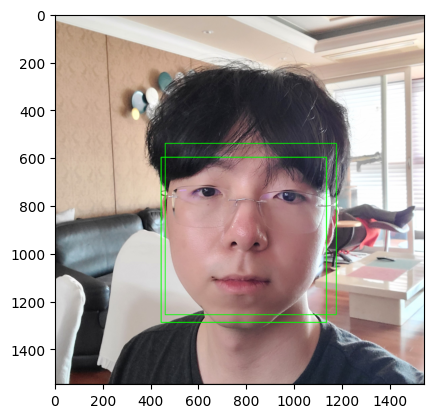

In [27]:
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

3. 얼굴 keypoint estimation
    * top-down : bounding box를 찾고 box 내부의 keypoint를 예측 (이번 예제 방식)
    * bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

In [29]:
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

/usr/bin/zsh: /home/komingsu/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
--2023-04-11 15:27:43--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  4.19MB/s    in 16s     

2023-04-11 15:27:59 (3.92 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [30]:
# !bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

/usr/bin/zsh: /home/komingsu/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)


In [31]:
# !rm shape_predictor_68_face_landmarks.dat.bz2

/usr/bin/zsh: /home/komingsu/miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /usr/bin/zsh)
rm: cannot remove 'shape_predictor_68_face_landmarks.dat.bz2': No such file or directory


In [33]:
model_path = 'shape_predictor_68_face_landmarks.dat'
    # 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

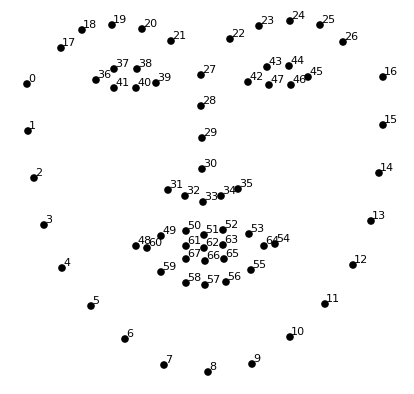

얼굴 keypoint 번호

In [34]:
list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성    

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


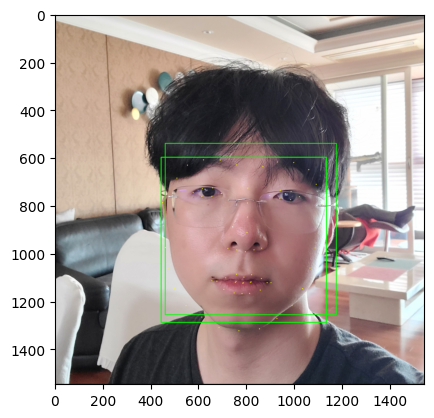

In [35]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

4. 스티커 적용하기
    * x 위치 = x_nose
    * y 위치 = y_nose + height/2
    * 스티커 크기 = width_bbox

In [36]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음
# dlib_rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[[(345, 98) (531, 284)]]
# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
# → [[(368, 153), (368, 174), (371, 195), (376, 215), (382, 235), (391, 252), (404, 266), (420, 277), (441, 279), (461, 276), (480, 266), (495, 252), (508, 235), (516, 216), (520, 195), (523, 173), (524, 151), (377, 131), (386, 119), (399, 116), (413, 118), (425, 124), (454, 121), (466, 114), (481, 112), (494, 114), (503, 127), (439, 143), (438, 156), (438, 169), (437, 182), (423, 197), (431, 199), (438, 200), (446, 199), (454, 197), (391, 147), (399, 142), (409, 143), (416, 149), (408, 150), (399, 150), (464, 147), (472, 141), (482, 141), (489, 145), (482, 149), (473, 149), (411, 227), (421, 222), (432, 218), (439, 220), (446, 218), (458, 222), (471, 227), (458, 234), (446, 238), (438, 238), (431, 238), (420, 235), (415, 227), (432, 227), (439, 228), (447, 227), (466, 227), (446, 228), (438, 229), (431, 228)]]

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0] # 이미지에서 코 부위의 x값
    y = landmark[30][1] - dlib_rect.height()//2 # 이미지에서 코 부위의 y값 - 얼굴 영역의 세로를 차지하는 픽셀의 수//2 → (437, 182-(186+1//2))
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531-345+1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(802, 913)
(x,y) : (802,568)
(w,h) : (692,692)


In [37]:
sticker_path = '../data/crown.png' # 왕관 이미지의 경로
img_sticker = cv2.imread(sticker_path) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인

(692, 692, 3)


In [38]:
# x,y,w,h 모두 위에서 반복문 안에서 지정해준 값임
# x는 이미지에서 코 부위의 x값 = 437
# y는 이미지에서 코 부위의 y값 = 89
# w는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 187
# h는 얼굴 영역의 가로를 차지하는 픽셀의 수 = 187
refined_x = x - w // 2 # 437 - (187//2) = 437-93 = 344
refined_y = y - h # 89-187 = -98
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정합니다. 이미지 시작점은 top-left 좌표이기 때문입니다.
# 즉, refined_x, refined_y값에서 왕관 이미지가 시작됨
print (f'(x,y) : ({refined_x},{refined_y})') # 음수 발생 : 이미지 범위를 벗어남
# 우리는 현재 이마 자리에 왕관을 두고 싶은건데, 이마위치 - 왕관 높이를 했더니 이미지의 범위를 초과하여 음수가 나오는 것


# opencv는 ndarray데이터를 사용하는데, ndarray는 음수인덱스에 접근 불가하므로 스티커 이미지를 잘라 줘야 한다.

(x,y) : (456,-124)


In [39]:
# 왕관 이미지가 이미지 밖에서 시작하지 않도록 조정이 필요함
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# 현재 상황에서는 -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하면 아래와 같은 형식으로 나옵니다.
# 음수값 만큼 왕관 이미지(혹은 추후 적용할 스티커 이미지)를 자른다.
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
# 왕관 이미지를 씌우기 위해 왕관 이미지가 시작할 y좌표 값 조정
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :] # refined_y가 -98이므로, img_sticker[98: , :]가 된다. (187, 187, 3)에서 (89, 187, 3)이 됨 (187개 중에서 98개가 잘려나감)
    refined_y = 0

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (456,0)


In [41]:
# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
# 예제에서는 (344,0) 부터 (344+187, 0+89) 범위의 이미지를 의미합니다.
# 좌표 순서가 y,x임에 유의한다. (y,x,rgb channel)
# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_show[0:0+89, 344:344+187]
# img_show[0:89, 344:531]
# 즉, x좌표는 344~531 / y좌표는 0~89가 됨
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

5. 결과

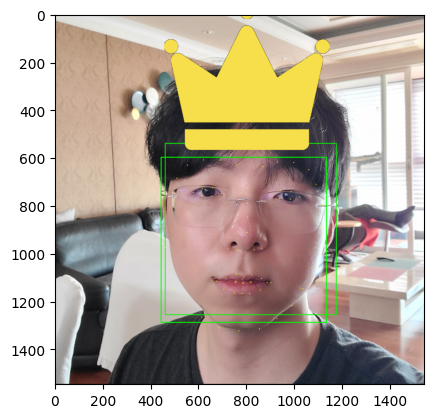

In [42]:
# 왕관 이미지를 적용한 이미지를 보여준다.
# 얼굴 영역(7-3)과 랜드마크(7-4)를 미리 적용해놓은 img_show에 왕관 이미지를 덧붙인 이미지가 나오게 된다.)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

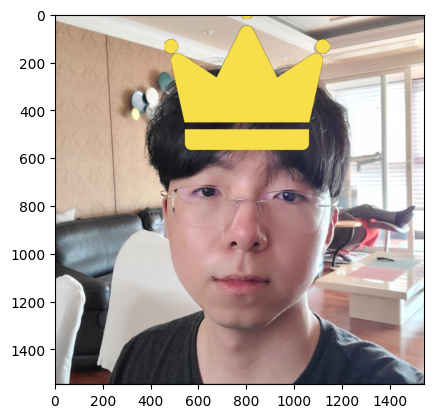

In [43]:
# 위에서 설명했으므로 생략
# 왕관 이미지
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
# img_bgr은 7-2에서 rgb로만 적용해놓은 원본 이미지이다. 
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)) # rgb만 적용해놓은 원본 이미지에 왕관 이미지를 덮어 씌운 이미지가 나오게 된다.
plt.show()

6. Task

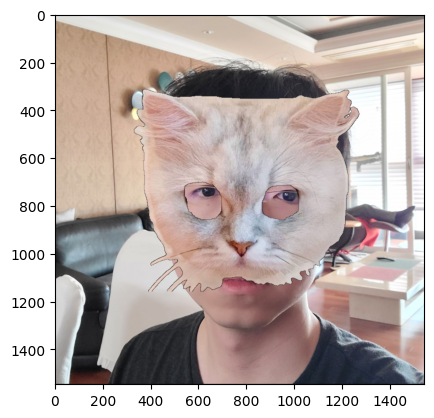

In [73]:
## Image load
my_image_path = '../data/selfi.jpg' # 본인 이미지가 있는 경로를 가지고 온다.
img = cv2.imread(my_image_path)
img_show = img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

## Face detect
detector_hog = dlib.get_frontal_face_detector() 
dlib_rects = detector_hog(img, 2)   

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom() 
    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)

## Face keypoint detect
model_path = 'shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

    ## detect
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

    ## keypoint value
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    nose_x = landmark[30][0]
    nose_y = landmark[30][1] - dlib_rect.height()//2 
    face_w = face_h = dlib_rect.width()

    ## sticker image
nose_sticker = '../data/cat.png'
nose_sticker = cv2.imread(nose_sticker)
nose_sticker = cv2.cvtColor(nose_sticker, cv2.COLOR_BGR2RGB)
nose_sticker = cv2.resize(nose_sticker, (w+300,h+200))

refined_x = x - w // 2 - 150
refined_y = y - 300

if refined_x < 0: 
    nose_sticker = nose_sticker[:, -refined_x:]
    refined_x = 0

if refined_y < 0:
    nose_sticker = nose_sticker[-refined_y:, :]
    refined_y = 0
    
sticker_area = img[refined_y:refined_y+nose_sticker.shape[0], refined_x:refined_x+nose_sticker.shape[1]]
img[refined_y:refined_y+nose_sticker.shape[0], refined_x:refined_x+nose_sticker.shape[1]] = np.where(nose_sticker==0,sticker_area,nose_sticker).astype(np.uint8)
plt.imshow(img)
plt.show()